#Seattle and Boston AirBNB homes price and reviews comparison

**Importing the Required Libraries**

In [1]:
import numpy as np #linear algebra
import pandas as pd #data processing, csv file i/0
import matplotlib.pyplot as plt #data plotting
import seaborn as sns #data visualization

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import os


**Import Data and Unzip**

In [2]:
! unzip "/content/Boston AirBnB Data Set.zip"

Archive:  /content/Boston AirBnB Data Set.zip
  inflating: Boston AirBnB Data Set/calendar.csv  
  inflating: Boston AirBnB Data Set/listings.csv  
  inflating: Boston AirBnB Data Set/reviews.csv  
  inflating: Seattle AirBnB Data Set/calendar.csv  
  inflating: Seattle AirBnB Data Set/listings.csv  
  inflating: Seattle AirBnB Data Set/reviews.csv  


**Check the Missing values proportion of both boston and seattle data**

In [3]:
#all seattle data, named with "_sl_"
#all boston data, named with "_bl"

df_sl = pd.read_csv("/content/Seattle AirBnB Data Set/listings.csv")
df_bl = pd.read_csv("/content/Boston AirBnB Data Set/listings.csv")

num_rows_s = df_sl.shape[0]
num_cols_s = df_sl.shape[1]

num_rows_b = df_sl.shape[0]
num_cols_b = df_sl.shape[1]

most_missing_cols_s = set(df_sl.columns[df_sl.isnull().mean() > 0.75])
most_missing_cols_b = set(df_bl.columns[df_bl.isnull().mean() > 0.75])

print(num_rows_s, num_cols_s, num_rows_b, num_cols_b)
print(most_missing_cols_s, most_missing_cols_b)

3818 92 3818 92
{'square_feet', 'license'} {'license', 'monthly_price', 'has_availability', 'neighbourhood_group_cleansed', 'square_feet', 'jurisdiction_names', 'weekly_price'}


**Data Wrangling First Step: Cleaning all numerical Data**



* drop all columns which have all unique values
* drop all columns which have most missing values
* convert dollar values to float values
* convert percentage values to float values
* introduce new review metric, since the both frequencies and review scores are important in measuring reviews





**Check the columns in both datasets**

In [4]:
df_sl.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [5]:
df_bl.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

**Basic data cleaning function for Seattle dataset**

In [6]:
def clean_dataset(df):
    '''
    INPUT
    df - pandas dataframe containing data 
    
    OUTPUT
    new_df - cleaned dataset, which contains:
    1. string containing price are converted into numbers;
    2. missing values are imputed with mean or mode or drop
    '''
    
    useless_columns = ['access', 'interaction', 'house_rules','name', 'host_name', 'square_feet', 'id', 'host_id','summary', 'space', 'description', 'neighborhood_overview', 'notes', 
                       'host_since', 'host_location', 'host_about', 'host_neighbourhood', 'host_total_listings_count', 'street', 'neighbourhood', 
                       'minimum_nights', 'maximum_nights', 'city', 'zipcode', 'smart_location', 'latitude', 
                       'longitude', 'is_location_exact', 'weekly_price', 'monthly_price', 'require_guest_profile_picture', 
                       'require_guest_phone_verification', 'calculated_host_listings_count', 'availability_30', 'availability_60', 'availability_90', 
                       'availability_365', 'calendar_updated','transit']
    
    # if all values are unique in this column, like ID, or if the values are url links, then drop it
    for col in df.columns:
        if len(df[col].unique()) == 1:
            df.drop(col, inplace=True, axis=1)
        if ('url' in col):
            df.drop(col, inplace=True, axis=1)
        if col in useless_columns:
            df.drop(col, inplace=True, axis=1)
    
    # generate review columns
    review_columns = []
    for col in df:
        if 'review' in col:
            review_columns.append(col)
    
    
    #convert all related 'price' columns values from string to number
    df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
    df['security_deposit'] = df['security_deposit'].str.replace("[$, ]", "").astype("float")
    df['cleaning_fee'] = df['cleaning_fee'].str.replace("[$, ]", "").astype("float")
    df['extra_people'] = df['extra_people'].str.replace("[$, ]", "").astype("float")
    #convert all percentage columns values to float number
    df['host_response_rate'] = df['host_response_rate'].str.replace("[%, ]", "").astype("float")/100
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace("[%, ]", "").astype("float")/100
    #generate new review metric
    df['new_review_metric'] = df['reviews_per_month'] * df['review_scores_rating']/100
    #drop original review columns
    df = df.drop(review_columns, axis=1)
    
    return df

**Apply the cleaned dataset function on the original dataset**

In [7]:
# Apply data cleaning functions above to clean dataset
clen_df_sl = clean_dataset(df_sl)
clen_df_bl = clean_dataset(df_bl)

# 'neighbourhood_group_cleansed' and 'state' are all null in Boston dataset, so we need to drop these two columns in Seattle dataset manually
clen_df_sl.drop('neighbourhood_group_cleansed', axis=1, inplace = True)
clen_df_sl.drop('state', axis=1, inplace = True)
clen_df_bl.drop('market', axis=1, inplace = True)

In [8]:
clen_df_sl.columns

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'instant_bookable', 'cancellation_policy', 'new_review_metric'],
      dtype='object')

In [9]:
clen_df_bl.columns

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'instant_bookable', 'cancellation_policy', 'new_review_metric'],
      dtype='object')

**Data Wrangling Second Step: Preprocessing the categorical data**

* Preprocessing the complicated multi-catigorical data which has no formal type (like 'amenities' and 'host_verifications')
* Generate dummy variables for the categorical data and avoid the Dummy Variable Regression to drop one dummy variables
* Since the real categories of the 'amenities' and 'host_verifications' may not affect the respondent variable, but the number of the categories may matter, generate the length of each rows

**Preprocessing the complicated multi-categorical data**

In [10]:
#cat_df_sl = clen_df_sl.copy()

def element_len(df, colname):
    coliloc = df.columns.get_loc(colname)
    
    for i, row in enumerate(df[colname]):
        df.iloc[i, coliloc] = row.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').replace(' ','')
        df.iloc[i, coliloc] = len(df.iloc[i, coliloc].split(','))
    return df

def create_dummy_df(df, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    # Dummy the categorical variables
    cat_cols = ['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'cancellation_policy']

    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [11]:
clen_df_sl = element_len(clen_df_sl, 'amenities')
clen_df_sl = element_len(clen_df_sl, 'host_verifications')

In [12]:
clen_df_bl = element_len(clen_df_bl, 'amenities')
clen_df_bl = element_len(clen_df_bl, 'host_verifications')

**Basic quantitive information from both datasets**

In [13]:
clen_df_sl.describe()

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,new_review_metric
count,3295.000000,3045.000000,3816.000000,3818.000000,3802.000000,3812.000000,3817.000000,3818.000000,1866.000000,2788.000000,3818.000000,3818.000000,3171.000000
mean,0.948868,0.999672,7.157757,3.349398,1.259469,1.307712,1.735394,127.976166,287.610397,61.710904,1.672603,10.667627,1.986119
std,0.118667,0.018122,28.628149,1.977599,0.590369,0.883395,1.139480,90.250022,270.222690,48.830341,1.311040,17.585922,1.744669
min,0.170000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,20.000000,95.000000,5.000000,0.000000,0.000000,0.018000
25%,0.980000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,75.000000,150.000000,25.000000,1.000000,0.000000,0.648000
50%,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,100.000000,250.000000,50.000000,1.000000,0.000000,1.478400
75%,1.000000,1.000000,3.000000,4.000000,1.000000,2.000000,2.000000,150.000000,300.000000,83.000000,2.000000,20.000000,2.871400
max,1.000000,1.000000,502.000000,16.000000,8.000000,7.000000,15.000000,1000.000000,5000.000000,300.000000,15.000000,300.000000,11.542500


In [14]:
clen_df_bl.describe()

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,new_review_metric
count,3114.000000,3114.000000,3585.000000,3585.000000,3571.000000,3575.000000,3576.000000,3585.000000,1342.000000,2478.000000,3585.000000,3585.000000,2772.000000
mean,0.949891,0.841731,58.902371,3.041283,1.221647,1.255944,1.609060,173.925802,324.698212,68.380145,1.429847,10.886192,1.855195
std,0.125177,0.217793,171.119663,1.778929,0.501487,0.753060,1.011745,148.331321,328.873075,51.297835,1.056787,19.137773,1.988579
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,10.000000,95.000000,5.000000,0.000000,0.000000,0.010000
25%,0.970000,0.710000,1.000000,2.000000,1.000000,1.000000,1.000000,85.000000,100.000000,25.000000,1.000000,0.000000,0.451150
50%,1.000000,0.940000,2.000000,2.000000,1.000000,1.000000,1.000000,150.000000,250.000000,50.000000,1.000000,0.000000,1.119300
75%,1.000000,1.000000,7.000000,4.000000,1.000000,2.000000,2.000000,220.000000,450.000000,100.000000,1.000000,20.000000,2.568200
max,1.000000,1.000000,749.000000,16.000000,6.000000,5.000000,16.000000,4000.000000,4500.000000,300.000000,14.000000,200.000000,18.001000


In [15]:
clen_df_sl = create_dummy_df(clen_df_sl, dummy_na=False)
clen_df_bl = create_dummy_df(clen_df_bl, dummy_na=False)

In [16]:
clen_df_sl = create_dummy_df(clen_df_sl, dummy_na=False)
clen_df_bl = create_dummy_df(clen_df_bl, dummy_na=False)

**Check the after data wrangling categorical columns**

In [17]:
len(clen_df_sl.columns)

28

In [18]:
len(clen_df_bl.columns)

29

In [19]:
for col in clen_df_bl:
    if col not in clen_df_sl:
        print(col)

cancellation_policy_super_strict_30


### Q1: What effects do AirBNB home properties have on prices in both east and west coasts ?


1. The relationship between bed or property type on price.

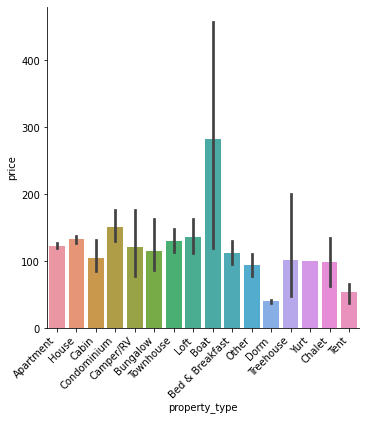

In [20]:
#Seattle
cpsl = sns.catplot(x='property_type', y='price', kind='bar', data=clen_df_sl)
cpsl.set_xticklabels(rotation=45, horizontalalignment='right')

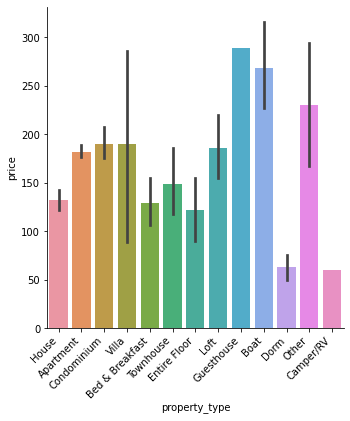

In [21]:
#Boston
cpbl=sns.catplot(x='property_type', y='price', kind='bar', data=clen_df_bl)
cpbl.set_xticklabels(rotation=45, horizontalalignment='right')

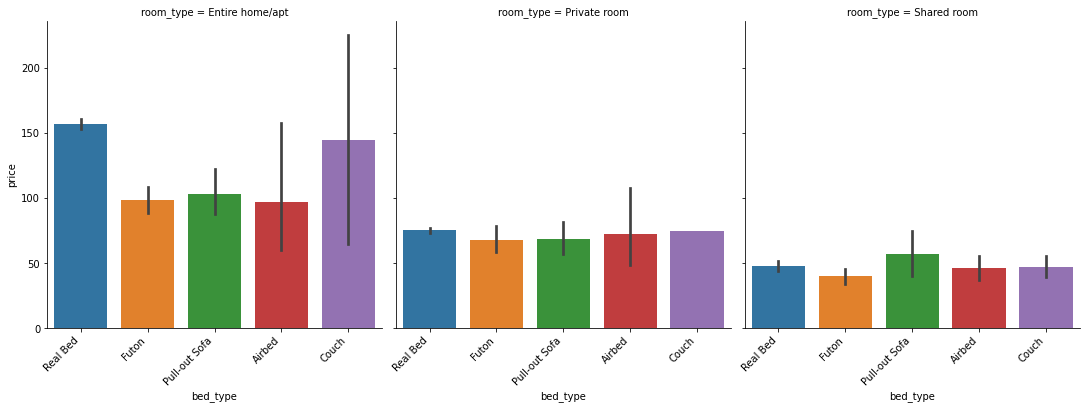

In [22]:
cbrpl=sns.catplot(x='bed_type', y='price', col = 'room_type', kind='bar', data=clen_df_sl)
cbrpl.set_xticklabels(rotation=45, horizontalalignment='right')

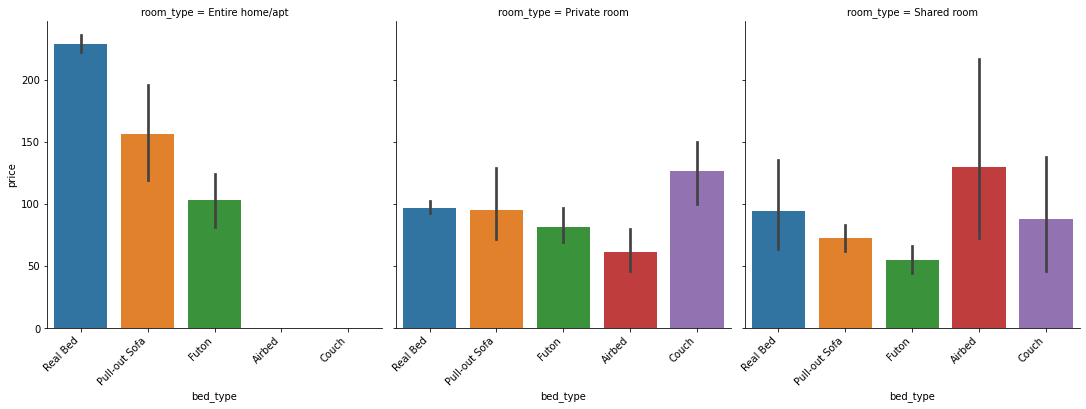

In [23]:
cbrbl=sns.catplot(x='bed_type', y='price', col = 'room_type', kind='bar', data=clen_df_bl)
cbrbl.set_xticklabels(rotation=45, horizontalalignment='right')

2. Relationship among the number of beds, bathrooms, bedrooms, accomodates and price

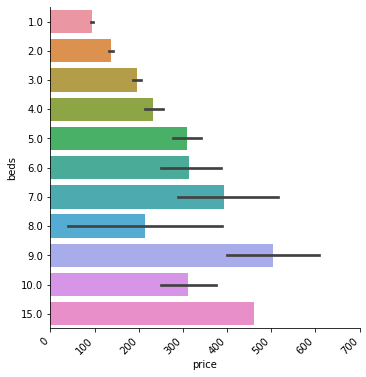

In [24]:
cbsl = sns.catplot(x='price', y='beds', orient='h', kind='bar', data=clen_df_sl)
cbsl.set_xticklabels(rotation=45, horizontalalignment='right')

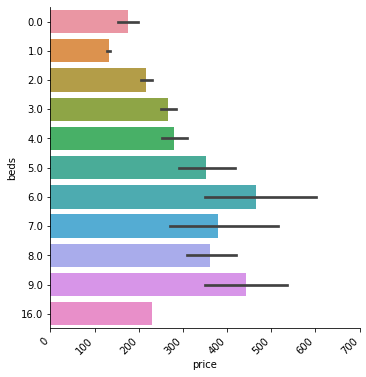

In [25]:
cbbl = sns.catplot(x='price', y='beds', orient='h', kind='bar', data=clen_df_bl)
cbbl.set_xticklabels(rotation=45, horizontalalignment='right')

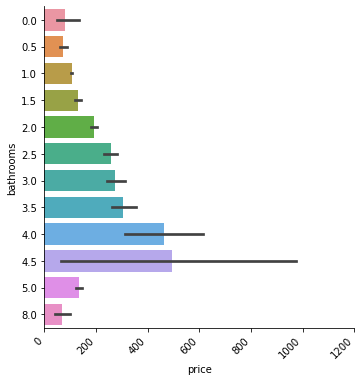

In [26]:
cbasl=sns.catplot(x='price', y='bathrooms', kind='bar', orient = 'h', data=clen_df_sl)
cbasl.set_xticklabels(rotation=45, horizontalalignment='right')

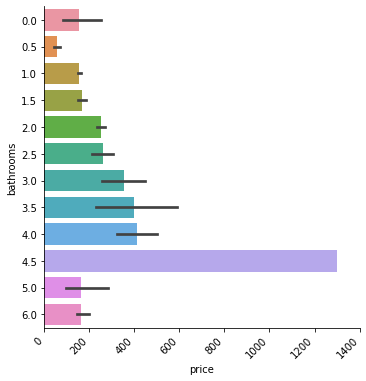

In [27]:
cbabl=sns.catplot(x='price', y='bathrooms', kind='bar', orient = 'h', data=clen_df_bl)
cbabl.set_xticklabels(rotation=45, horizontalalignment='right')

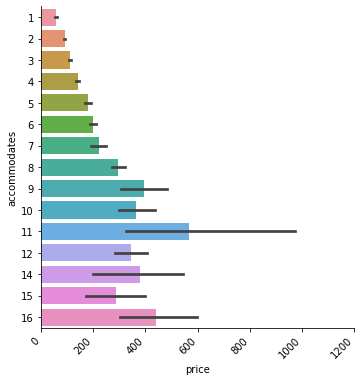

In [28]:
casl=sns.catplot(x='price', y='accommodates', orient = 'h', kind='bar',data=clen_df_sl)
casl.set_xticklabels(rotation=45, horizontalalignment='right')

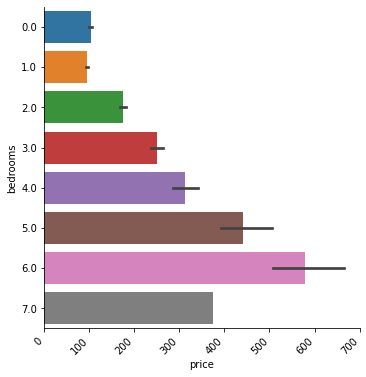

In [29]:
cbesl=sns.catplot(x='price', y='bedrooms', orient = 'h', kind='bar',data=clen_df_sl)
cbesl.set_xticklabels(rotation=45, horizontalalignment='right')

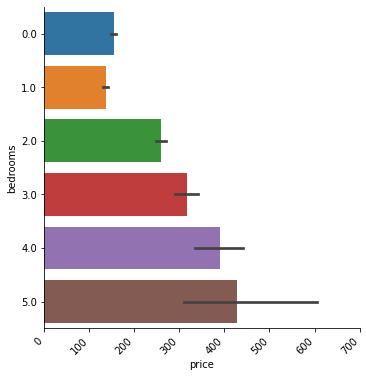

In [30]:
cbebl=sns.catplot(x='price', y='bedrooms', orient = 'h', kind='bar',data=clen_df_bl)
cbebl.set_xticklabels(rotation=45, horizontalalignment='right')

### Q2: What host's behaviors or profiles would influence AirBNB tenants reviews in both west and east coasts?

In [31]:
#generate new behavior_review dataframe for analysis

behavior_review_bl_cols = ['host_response_rate', 'host_acceptance_rate',
                        'host_response_time_within a day',
                        'host_response_time_within a few hours',
                        'host_response_time_within an hour',
                        'host_has_profile_pic_t', 
                        'host_identity_verified_t', 
                        'host_is_superhost_t', 
                        'instant_bookable_t', 
                        'cancellation_policy_moderate',
                        'cancellation_policy_strict',
                        'cancellation_policy_super_strict_30',
                        'amenities',
                        'host_verifications',
                        'guests_included', 'extra_people', 'price',
                        'new_review_metric']
                      
behavior_review_sl_cols = behavior_review_bl_cols.copy()
behavior_review_sl_cols.remove('cancellation_policy_super_strict_30')

behavior_review_sl = clen_df_sl[behavior_review_sl_cols].copy()
behavior_review_bl = clen_df_bl[behavior_review_bl_cols].copy()

**Correlation between Seattle's review and behavior features**

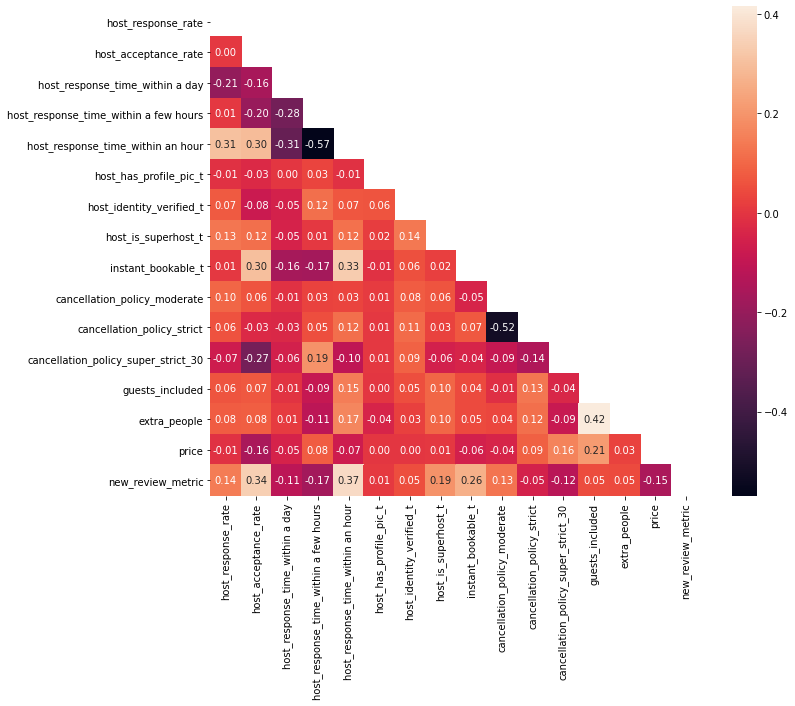

In [32]:
corr = behavior_review_bl.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.rcParams['figure.figsize'] = [11, 9]
sns.heatmap(corr, mask=mask, annot = True, fmt=".2f")

### Q3: Which AirBNB listing property is the most import one in reviews ?

In [34]:
#copy the cleaned dataset
review_df_sl = clen_df_sl.copy()
review_df_bl = clen_df_bl.copy()

In [38]:
def fin_clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # drop irrelavent variables
    irrelavent_cols = ['cleaning_fee', 'security_deposit', 'host_verifications']
    
    for col in  irrelavent_cols:
        # for each cat add dummy var, drop original column
        df = df.drop(col, axis=1)
    
    # Drop rows with missing salary values
    df = df.dropna(subset=['new_review_metric'], axis=0)
    y = df['new_review_metric']
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        


    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
    #    # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

    X = df.drop(['new_review_metric'], axis=1)
    #X = df['host_acceptance_rate'].values

    return X, y 

In [39]:
#Use the above function to finalize the data preprocessing for X and y
X_sl, y_sl = fin_clean_data(review_df_sl)
X_bl, y_bl = fin_clean_data(review_df_bl)

**Splitting the training set and test set**

In [40]:
#Split into train and test
X_train_sl, X_test_sl, y_train_sl, y_test_sl = train_test_split(X_sl, y_sl, test_size=0.3, random_state=42)
X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(X_bl, y_bl, test_size=0.3, random_state=42)

sc = StandardScaler()
X_train_sl = sc.fit_transform(X_train_sl)
X_test_sl = sc.transform(X_test_sl)
X_train_bl = sc.fit_transform(X_train_bl)
X_test_bl = sc.transform(X_test_bl)


**Generate the Random Forest Regressor for data modelling**

In [41]:
regressor_sl = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=42, n_jobs=-1)
regressor_bl = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=42, n_jobs=-1)


In [42]:
regressor_sl.fit(X_train_sl, y_train_sl.squeeze())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [43]:
regressor_bl.fit(X_train_bl, y_train_bl.squeeze())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

**The model accuracies and validation analysis**

In [45]:
y_train_sl_preds = regressor_sl.predict(X_train_sl)
y_test_sl_preds = regressor_sl.predict(X_test_sl)

print('Random Forest MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train_sl, y_train_sl_preds), mean_squared_error(y_test_sl, y_test_sl_preds)))
print('Random Forest MSE train: %.3f, test: %.3f' % (r2_score(y_train_sl, y_train_sl_preds), r2_score(y_test_sl, y_test_sl_preds)))


Random Forest MSE train: 0.267, test: 2.161
Random Forest MSE train: 0.910, test: 0.322


In [46]:
y_train_bl_preds = regressor_bl.predict(X_train_bl)
y_test_bl_preds = regressor_bl.predict(X_test_bl)

print('Random Forest MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train_bl, y_train_bl_preds), mean_squared_error(y_test_bl, y_test_bl_preds)))
print('Random Forest MSE train: %.3f, test: %.3f' % (r2_score(y_train_bl, y_train_bl_preds), r2_score(y_test_bl, y_test_bl_preds)))


Random Forest MSE train: 0.313, test: 2.699
Random Forest MSE train: 0.917, test: 0.384


Feature importancies ranking plot for both Seattle's and Boston's reviews

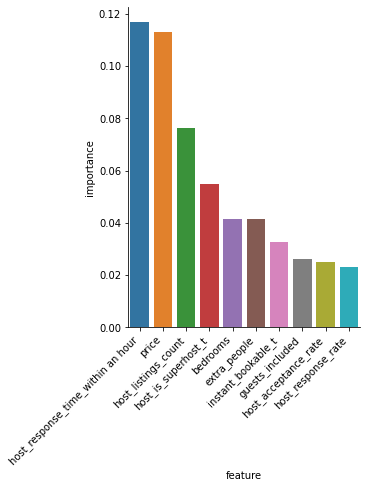

In [47]:
importances = regressor_sl.feature_importances_
feat_names = X_sl.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result_sort = tree_result.sort_values(by='importance',ascending=False)[:10]
chart = sns.catplot(x='feature', y='importance', kind='bar', data=tree_result_sort)
chart.set_xticklabels(rotation=45, horizontalalignment='right')
#chart.set_titles("Seattle's feature importances analysis for reviews")

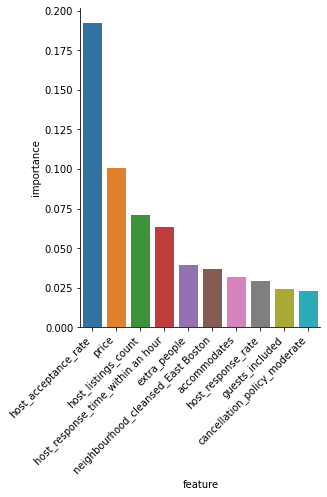

In [48]:
importances = regressor_bl.feature_importances_
feat_names = X_bl.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result_sort = tree_result.sort_values(by='importance',ascending=False)[:10]
chart = sns.catplot(x='feature', y='importance', kind='bar', data=tree_result_sort)
chart.set_xticklabels(rotation=45, horizontalalignment='right')
#chart.set_titles("Boston's feature importances analysis for reviews")